Loading MatrixMarket (.mtx) file...
Graph loaded successfully!
Nodes: 17206
Edges: 604867

--- BASIC STRUCTURAL PROPERTIES ---
Density: 0.004086535643794365
Average degree: 70.30884575148204
Max degree: 1709


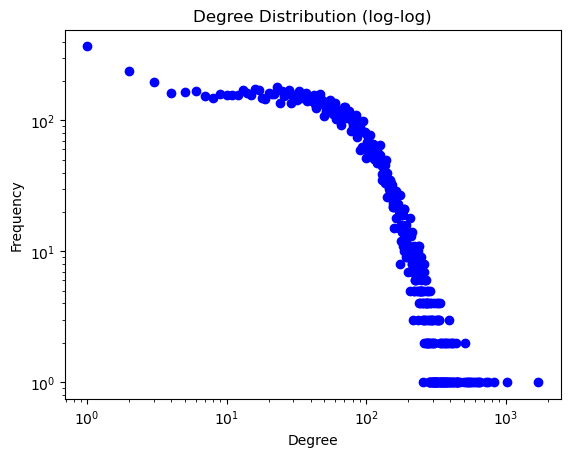


--- CENTRALITIES ---
Computing approximate betweenness (k=300)...
Computing approximate closeness (400 samples)...

Top 5 betweenness:
[(852, 0.049668501896223606), (14539, 0.014878704903451296), (2291, 0.006375497441210786), (10754, 0.006269571658756439), (1100, 0.005953825162485511)]

Top 5 closeness:
[(852, 0.5037783375314862), (14539, 0.4819277108433735), (10754, 0.46893317702227433), (13147, 0.46296296296296297), (16568, 0.4608294930875576)]

--- CONNECTED COMPONENTS ---
Number of components: 1
Largest component: 17206


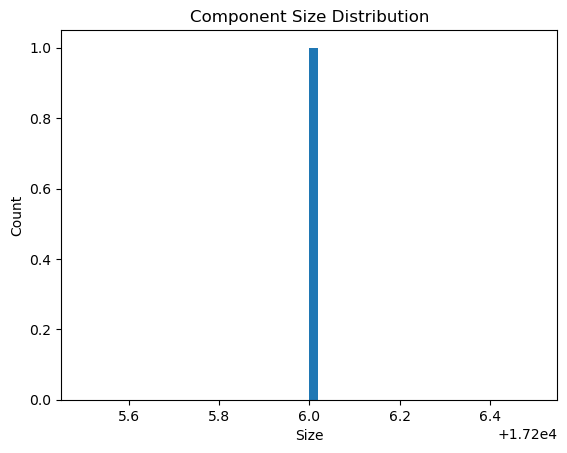


Drawing subgraph of top hubs...


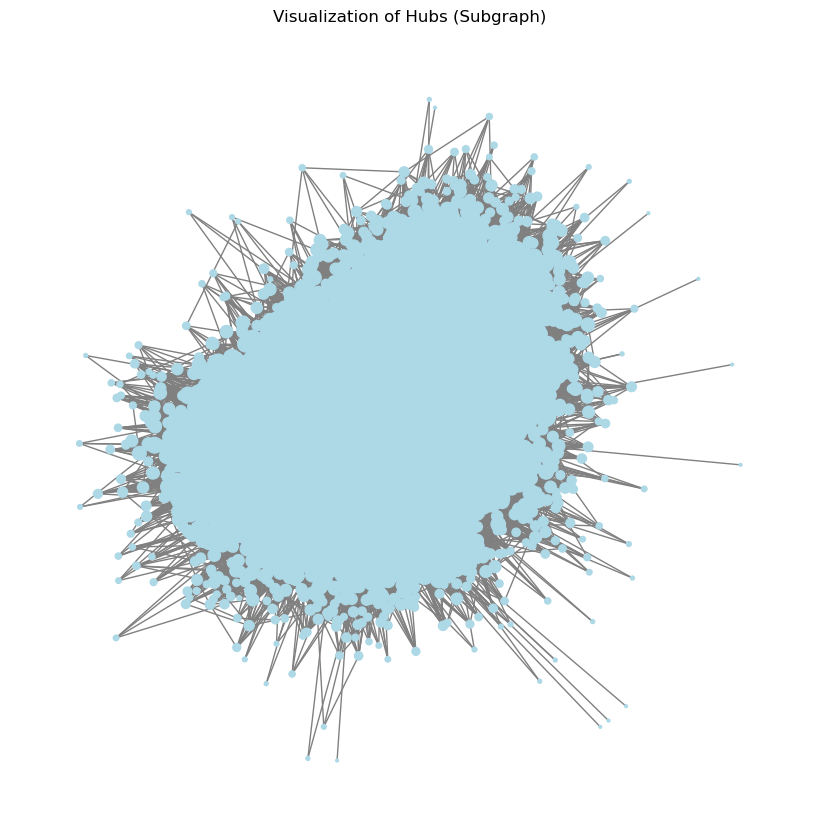

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import statistics
from scipy.io import mmread   # <-- Correct import

# =========================
# LOAD .MTX GRAPH
# =========================

FILE = "socfb-UConn.mtx"   # <-- set your file here

print("Loading MatrixMarket (.mtx) file...")
A = mmread(FILE)                     # SciPy loads sparse matrix
G = nx.from_scipy_sparse_array(A)    # convert to NetworkX Graph

G = nx.Graph(G)                       # ensure simple undirected
G.remove_edges_from(nx.selfloop_edges(G))

print("Graph loaded successfully!")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# =========================
# a) BASIC STRUCTURAL PROPERTIES
# =========================

# i) N, M, Density
n, m = G.number_of_nodes(), G.number_of_edges()
density = nx.density(G)
print("\n--- BASIC STRUCTURAL PROPERTIES ---")
print("Density:", density)

# ii) Degree statistics
degrees = [d for _, d in G.degree()]
avg_deg = sum(degrees)/n
max_deg = max(degrees)

print("Average degree:", avg_deg)
print("Max degree:", max_deg)

deg_count = collections.Counter(degrees)
x, y = zip(*sorted(deg_count.items()))

plt.figure()
plt.loglog(x, y, 'bo')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (log-log)")
plt.show()


# iii) CENTRALITIES (approx)
print("\n--- CENTRALITIES ---")
print("Computing approximate betweenness (k=300)...")
bet = nx.betweenness_centrality(G, k=300)

print("Computing approximate closeness (400 samples)...")
sample_nodes = list(G.nodes())[:400]
clo = {}
for s in sample_nodes:
    lengths = nx.single_source_shortest_path_length(G, s)
    for node, dist in lengths.items():
        clo[node] = clo.get(node, 0) + dist
clo = {node: (400 / clo[node]) if clo[node] != 0 else 0 for node in clo}

print("\nTop 5 betweenness:")
print(sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 closeness:")
print(sorted(clo.items(), key=lambda x: x[1], reverse=True)[:5])


# v) CONNECTED COMPONENTS
components = list(nx.connected_components(G))
sizes = [len(c) for c in components]

print("\n--- CONNECTED COMPONENTS ---")
print("Number of components:", len(sizes))
print("Largest component:", max(sizes))

plt.figure()
plt.hist(sizes, bins=50)
plt.title("Component Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")
plt.show()


# vi) VISUALIZATION (local subgraph)
print("\nDrawing subgraph of top hubs...")

hub_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:80]
hub_nodes = [n for n,_ in hub_nodes]

neighbors = set()
for v in hub_nodes:
    neighbors.update(G.neighbors(v))

draw_nodes = list(set(hub_nodes) | neighbors)
H = G.subgraph(draw_nodes)

pos = nx.spring_layout(H, seed=42)
node_sizes = [4 * H.degree(v) for v in H.nodes()]

plt.figure(figsize=(8,8))
nx.draw(H, pos, node_size=node_sizes, node_color='lightblue', edge_color='gray')
plt.title("Visualization of Hubs (Subgraph)")
plt.show()
